In [55]:
!pip install fuzzywuzzy

## Imports

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import resource
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
import warnings

color = sns.color_palette()
stopwords = set(stopwords.words('english'))

%matplotlib inline
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data reading

In [57]:
df = pd.read_csv('/content/quora_duplicate_questions.tsv', sep='\t')

## Data Understanding

In [58]:
print("Number of data points:",df.shape[0])
print("Number of features:",df.shape[1])

Number of data points: 404290
Number of features: 6


In [59]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [60]:
df.tail()

,id,qid1,qid2,question1,question2,is_duplicate
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0
404289,404289,537932,537933,What is like to have sex with cousin?,What is it like to have sex with your cousin?,0


##EDA

In [61]:
len(df)

404290

Dataset with question pairs of 404287 size

### Target Variable Distribution

In [62]:
df['is_duplicate'].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

<Axes: xlabel='is_duplicate'>

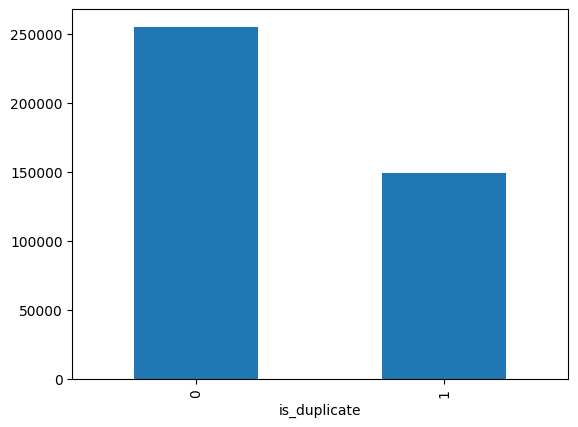

In [63]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [64]:
len(df[df['is_duplicate'] == 0])/len(df) * 100

63.08021469737069

In [65]:
len(df[df['is_duplicate'] == 1])/len(df) * 100

36.9197853026293

We have 63% of non-similar question pairs and 37% of similar question pairs from the calculations above

This indicates that possibly our dataset is imbalanced.

### Unique questions details

In [66]:
print(len(df[df.isnull().any(axis=1)]))
df = df.fillna('')
print(len(df[df.isnull().any(axis=1)]))

3
0


In [67]:
questions_combined = np.concatenate([df['question1'], df['question2']])

In [68]:
full_questions_df = pd.DataFrame(questions_combined, columns=['questions'])

In [69]:
full_questions_df['questions'].nunique()

537361

In [70]:
question_wise_value_counts = full_questions_df['questions'].value_counts()

In [71]:
print(np.sum(question_wise_value_counts > 1))
print(round(np.sum(question_wise_value_counts > 1)/len(set(questions_combined)) * 100, 2))

111873
20.82


In [72]:
print(np.sum(question_wise_value_counts == 1))
print(round(np.sum(question_wise_value_counts == 1)/len(set(questions_combined)) * 100, 2))

425488
79.18


So there are total 537361 unique questions in our dataset.

And there are 111872 questions repeated more than once which is 20.82% of unique questions.

And 425488 questions appeared only once means 79.18% of total unique questions

In [73]:
print(question_wise_value_counts.index[0])
question_wise_value_counts[0]

What are the best ways to lose weight?


161

Most common question: **What are the best ways to lose weight?**

It appeared 161 times

### Each question occurences count

Text(0, 0.5, 'Number of questions')

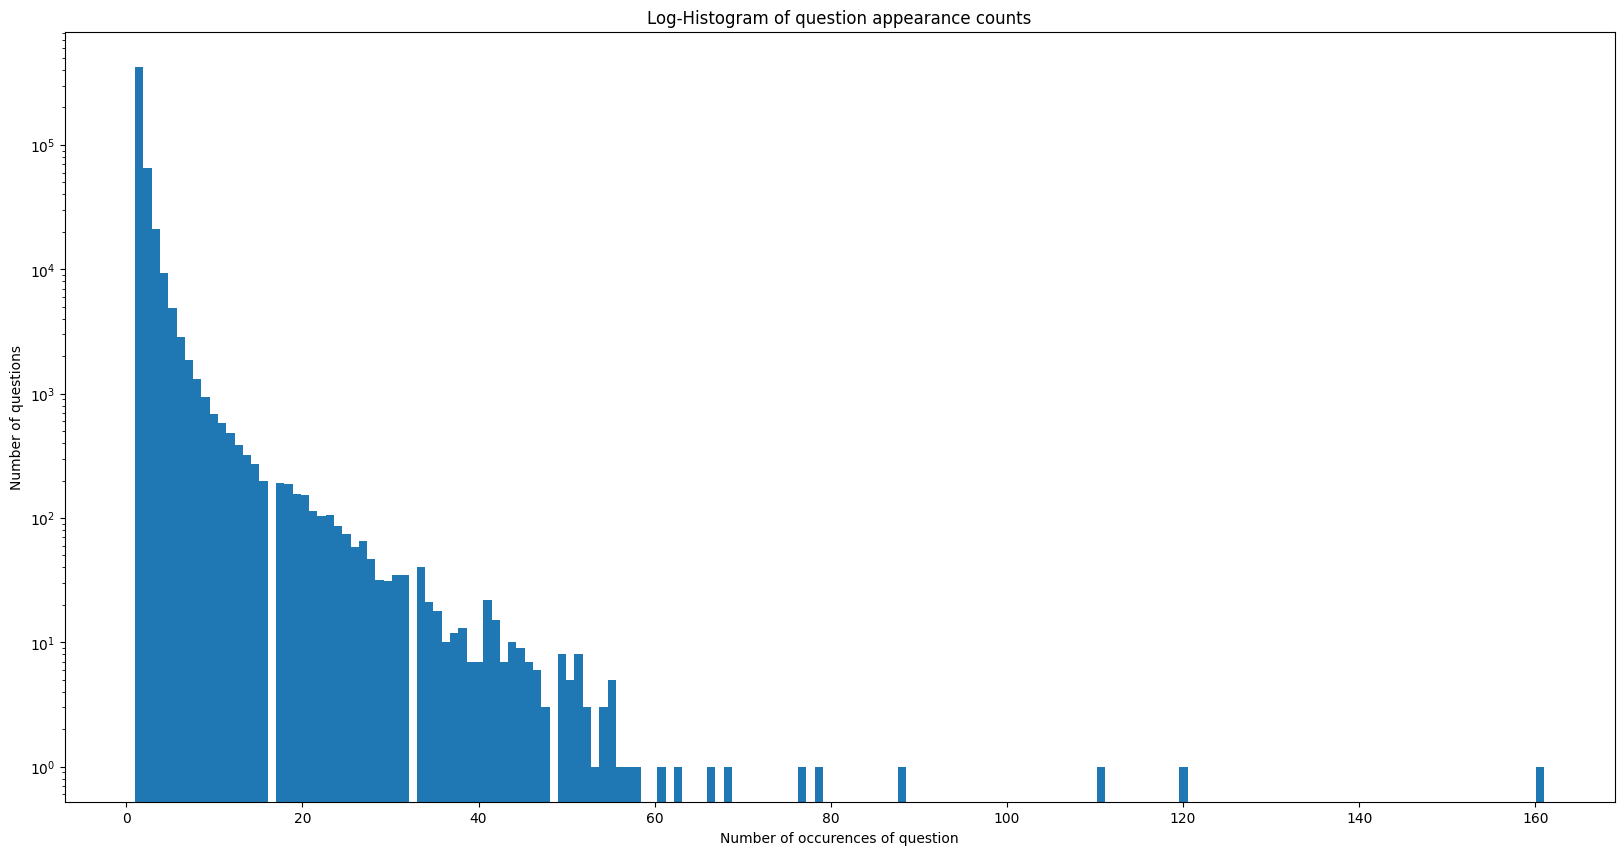

In [74]:
plt.figure(figsize=(20, 10))
plt.hist(question_wise_value_counts, bins=170)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

From the above histogram graph we can see that most of the questions repeated maxium of 50 times. Other questions those appeared more than 60 times are very less. As we know the most repeated question appeared to be 161 times.

### Word distribution of questions

How words are distributed in question pairs. This feature allows us to understand word level distribution of the questions.

In [75]:
full_questions_df['number_of_words'] = full_questions_df["questions"].str.split().apply(len)

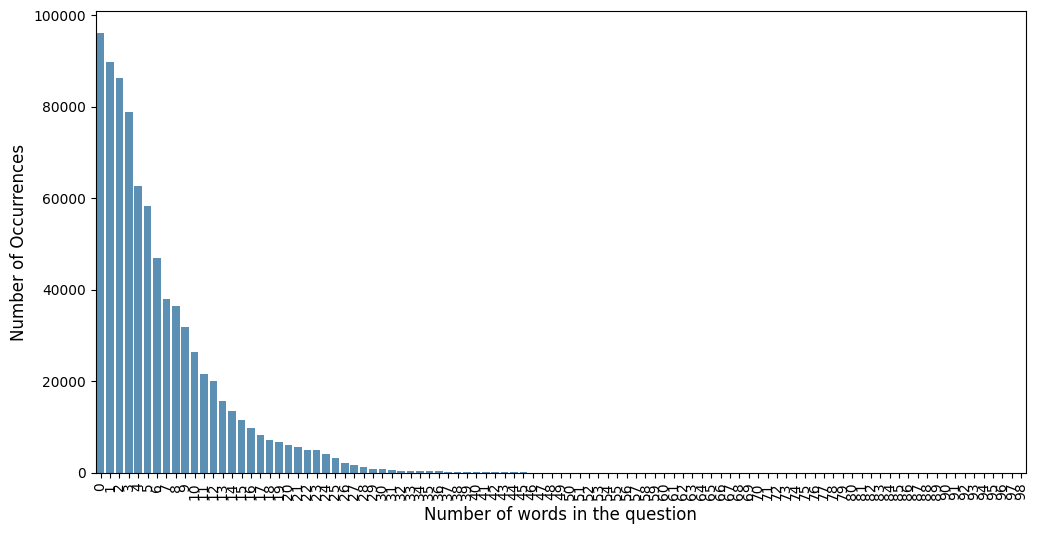

In [76]:
cnt_srs = full_questions_df['number_of_words'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Character distribution

How character legths varies in question pairs. This feature allows us to understand character level distribution of the questions.

In [78]:
full_questions_df['number_of_chars'] = full_questions_df["questions"].apply(len)

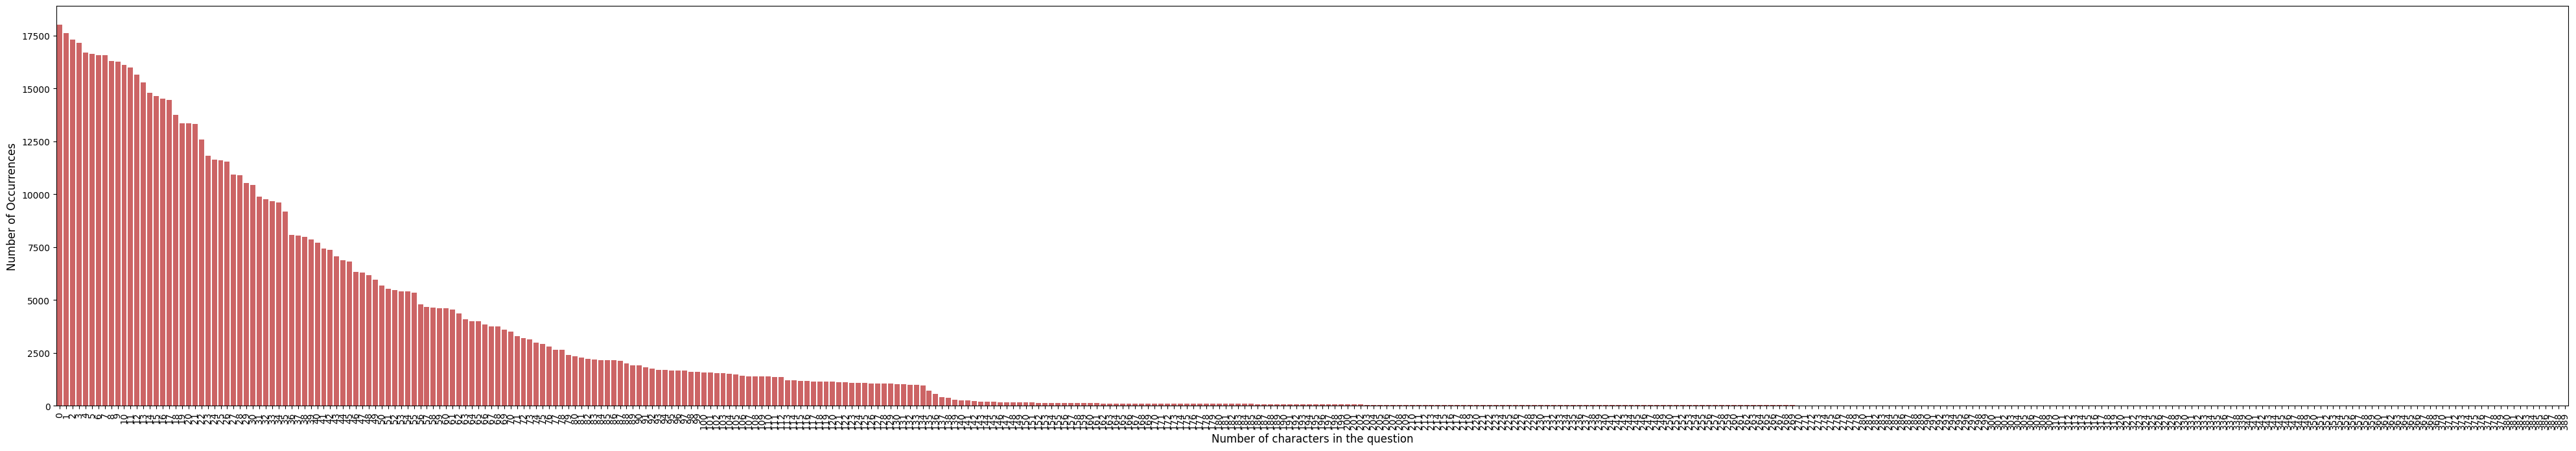

In [79]:
cnt_srs = full_questions_df['number_of_chars'].value_counts()

plt.figure(figsize=(50,8))
sns.barplot(cnt_srs.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Unigrams

By understanding the unigrams present in our question pairs we can understand common unigrams present in our questions.

In [80]:
def unigrams(question):
    return [word for word in word_tokenize(question.lower()) if word not in stopwords]

def common_unigrams(row_data):
    return len( set(row_data["unigrams_ques1"]).intersection(set(row_data["unigrams_ques2"])) )

def common_unigram_ratio(row_data):
    return float(row_data["unigrams_common_count"]) / max(len( set(row_data["unigrams_ques1"]).union(set(row_data["unigrams_ques2"])) ),1)

df["unigrams_ques1"] = df['question1'].apply(lambda x: unigrams(str(x)))
df["unigrams_ques2"] = df['question2'].apply(lambda x: unigrams(str(x)))
df["unigrams_common_count"] = df.apply(lambda row: common_unigrams(row),axis=1)
df["unigrams_common_ratio"] = df.apply(lambda row: common_unigram_ratio(row), axis=1)

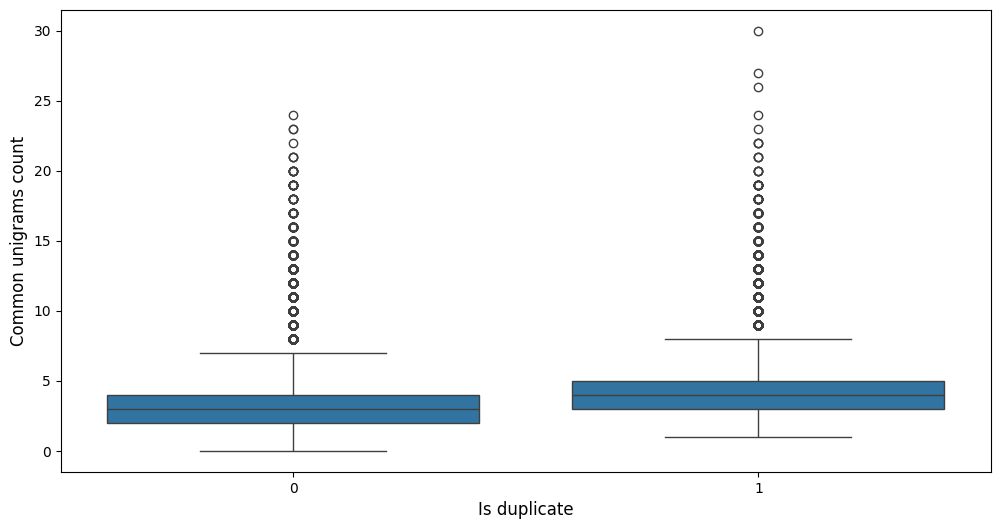

In [81]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_duplicate", y="unigrams_common_count", data=df)
plt.xlabel('Is duplicate', fontsize=12)
plt.ylabel('Common unigrams count', fontsize=12)
plt.show()

We see there is some count of common unigrams present in our question and we have some significant change in count among two target classes which will be useful for the modelling.

## Data Preprocessing

### Missing values

In [82]:
#Checking whether there are any rows with null values
null_rows = df[df.isnull().any(axis=1)]
null_rows

,id,qid1,qid2,question1,question2,is_duplicate,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio


In [83]:
# Rows with null values are removed
print(df.shape)
df = df[~df.isnull().any(axis=1)]
print(df.shape)

(404290, 10)
(404290, 10)


### Data Cleaning

Text data cleaning needs to be done to make sure we deal with proper data. Different NLP stratergies listed below are followed

In [84]:
def clean_sentence(text):
    if pd.isnull(text):
        return ''

    if type(text) != str or text=='':
        return ''
    ps = PorterStemmer()

    text = re.sub("\'s", " ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = text.replace("can't", "can not")
    text = re.sub("\'re", " are ", text)
    text = text.replace(" whats ", " what is ")
    text = re.sub("\'ve", " have ", text)
    text = re.sub("n't", " not ", text)
    text = text.replace("b\.g\.", " bg ")
    text = re.sub("\'d", " would ", text)
    text = text.replace("\'ll", " will ")
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = text.replace("e\.g\.", " eg ")
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)

    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = text.replace('\$', " dollar ")
    text = text.replace('\%', " percent ")
    text = text.replace('\&', " and ")

    text = ' '.join([word for word in text.split(" ") if word not in stopwords]).lower()
    #text = ' '.join([ps.stem(word) for word in text])
    return text

In [85]:
df["question1"] = df["question1"].fillna("").apply(clean_sentence)
df["question2"] = df["question2"].fillna("").apply(clean_sentence)

## Feature Engineering

### Basic Textual Features

In [86]:
def get_unique_words(sentence):
  sent_split = sentence.split(" ")
  sent_split_processed = [word.lower().strip() for word in sent_split]
  return set(sent_split_processed)


def word_common_details(row):
    words1 = get_unique_words(row['question1'])
    words2 = get_unique_words(row['question2'])
    return 1.0 * len(words1 & words2)

def word_count_details(row):
    words1 = get_unique_words(row['question1'])
    words2 = get_unique_words(row['question2'])
    return 1.0 * (len(words1) + len(words2))

def word_share_data(row):
    words1 = get_unique_words(row['question1'])
    words2 = get_unique_words(row['question2'])
    return 1.0 * len(words1 & words2)/(len(words1) + len(words2))


In [87]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['diff_len'] = df.q1len - df.q2len

df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(' ')))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(' ')))

df['len_char_q1'] = df.question1.apply(lambda x: len(''.join(set(str(x)))))
df['len_char_q2'] = df.question2.apply(lambda x: len(''.join(set(str(x)))))

df['len_word_q1'] = df.question1.apply(lambda x: len(str(x).split()))
df['len_word_q2'] = df.question2.apply(lambda x: len(str(x).split()))

df['word_Common'] = df.apply(word_common_details, axis=1)
df['word_Total'] = df.apply(word_count_details, axis=1)
df['word_share'] = df.apply(word_share_data, axis=1)

### Similarity Features

To get semantic features we used 'word2vec-google-news-300' model to get the vector representation of the questions first then find the similarity score using the different distance measures

In [88]:
import gensim.downloader as api
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

# model = api.load('word2vec-google-news-300')

In [89]:
def get_sent_vector_repr(sent):
    tokens = str(sent).lower()
    tokens = word_tokenize(tokens)
    tokens = [w for w in tokens if w.isalpha()]
    sentence_vector = []
    for w in tokens:
        try:
            sentence_vector.append(model[w])
        except:
            continue
    sentence_vector = np.array(sentence_vector)
    vector = sentence_vector.sum(axis=0)
    return vector / np.sqrt((vector ** 2).sum())

In [90]:
from tqdm.notebook import tqdm

vectors_question1 = np.zeros((df.shape[0], 300))
for index, question in enumerate(tqdm(df['question1'].values)):
    vectors_question1[index, :] = get_sent_vector_repr(question)

vectors_question2  = np.zeros((df.shape[0], 300))
for index, question in enumerate(tqdm(df['question2'].values)):
    vectors_question2[index, :] = get_sent_vector_repr(question)

  0%|          | 0/404290 [00:00<?, ?it/s]

  0%|          | 0/404290 [00:00<?, ?it/s]

In [91]:
df['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(vectors_question1), np.nan_to_num(vectors_question2))]
df['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(vectors_question1), np.nan_to_num(vectors_question2))]
df['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(vectors_question1), np.nan_to_num(vectors_question2))]
df['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(vectors_question1), np.nan_to_num(vectors_question2))]
df['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(vectors_question1), np.nan_to_num(vectors_question2))]
df['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(vectors_question1), np.nan_to_num(vectors_question2))]
df['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(vectors_question1), np.nan_to_num(vectors_question2))]

### Substring level features

In [92]:
df['fuzz_qratio'] = df.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
# df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
# df['fuzz_WRatio'] = df.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1)
# df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
# df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
# df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
# df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [93]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio,...,word_Total,word_share,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,fuzz_qratio
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,"[step, step, guide, invest, share, market, ind...","[step, step, guide, invest, share, market, ?]",6,0.857143,...,13.0,0.384615,0,0.0,0,0.0,0.0,0.0,NaN,93
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,"[story, kohinoor, (, koh-i-noor, ), diamond, ?]","[would, happen, indian, government, stole, koh...",6,0.461538,...,15.0,0.200000,0,0.0,0,0.0,0.0,0.0,NaN,66
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns, ?]",3,0.300000,...,14.0,0.214286,0,0.0,0,0.0,0.0,0.0,NaN,47
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,"[mentally, lonely, ?, solve, ?]","[find, remainder, [, math, ], 23^, {, 24, }, [...",1,0.062500,...,12.0,0.000000,0,0.0,0,0.0,0.0,0.0,NaN,28
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,"[one, dissolve, water, quikly, sugar, ,, salt,...","[fish, would, survive, salt, water, ?]",3,0.200000,...,17.0,0.058824,0,0.0,0,0.0,0.0,0.0,NaN,33


In [94]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'unigrams_ques1', 'unigrams_ques2', 'unigrams_common_count',
       'unigrams_common_ratio', 'q1len', 'q2len', 'diff_len', 'freq_qid1',
       'freq_qid2', 'freq_q1+q2', 'freq_q1-q2', 'q1_n_words', 'q2_n_words',
       'len_char_q1', 'len_char_q2', 'len_word_q1', 'len_word_q2',
       'word_Common', 'word_Total', 'word_share', 'cosine_distance',
       'cityblock_distance', 'jaccard_distance', 'canberra_distance',
       'euclidean_distance', 'minkowski_distance', 'braycurtis_distance',
       'fuzz_qratio'],
      dtype='object')

### Plots understand features extracted

#### shared words plot and distribution

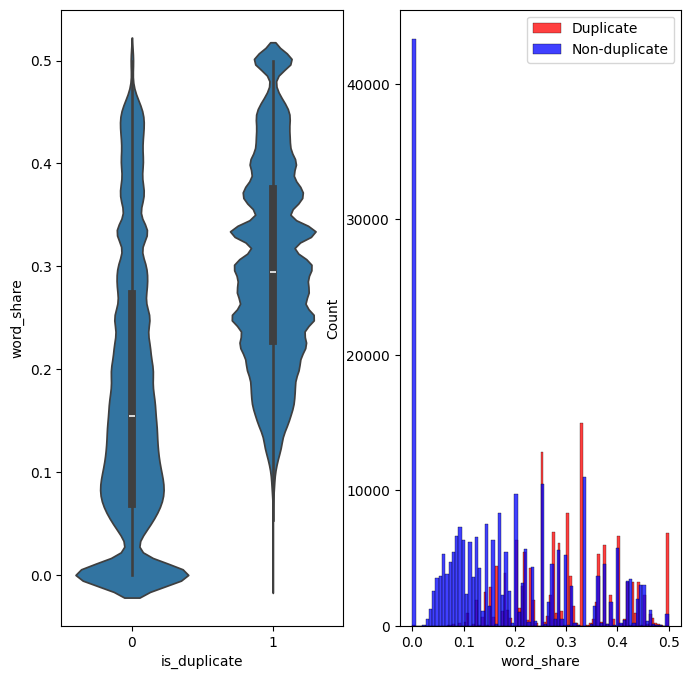

In [95]:
plt.figure(figsize=(8, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "Duplicate", color = 'red')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "Non-duplicate" , color = 'blue' )
plt.legend()
plt.show();

#### common words plot & distribution

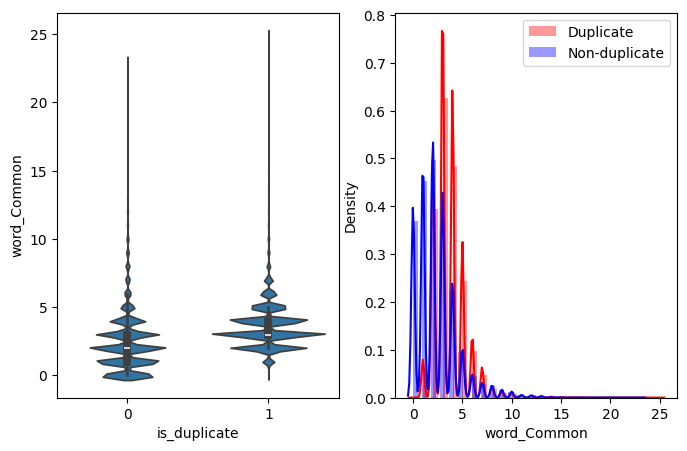

In [96]:
plt.figure(figsize=(8,5))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "Duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "Non-duplicate" , color = 'blue' )
plt.legend()
plt.show();

#### total words plots and distribution

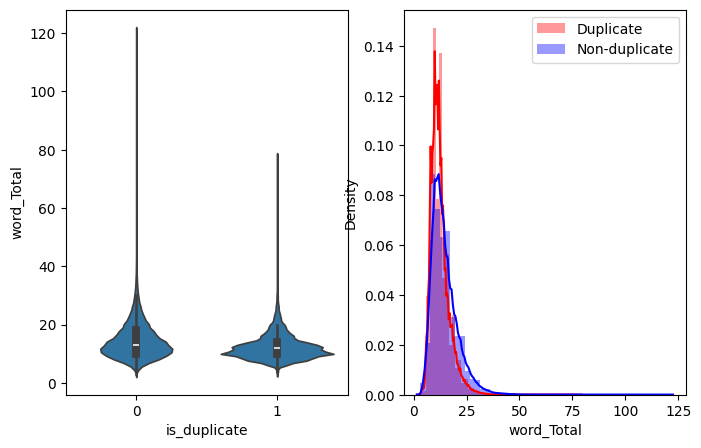

In [97]:
plt.figure(figsize=(8, 5))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Total', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Total'][0:] , label = "Duplicate", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Total'][0:] , label = "Non-duplicate" , color = 'blue' )
plt.legend()
plt.show();

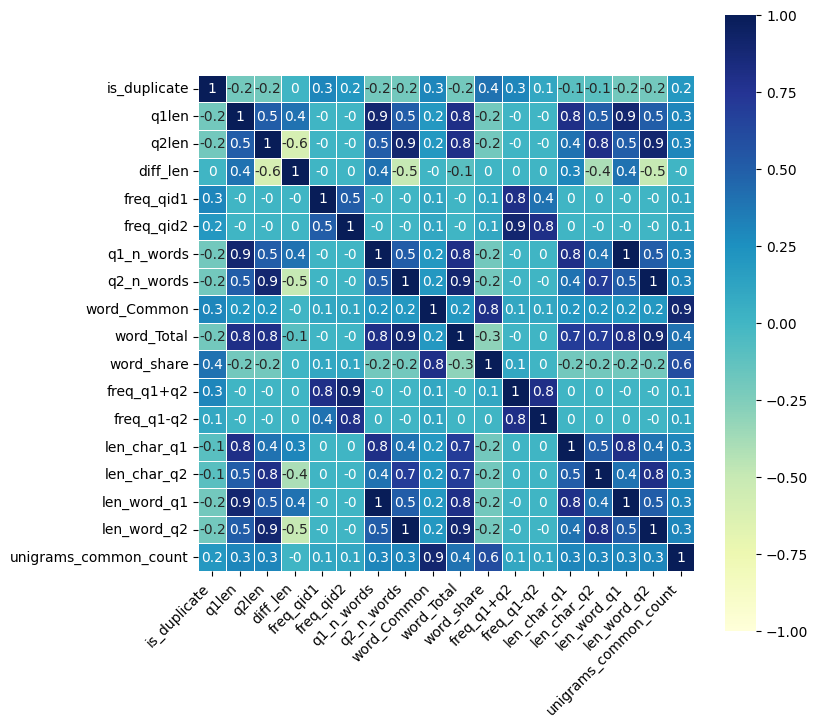

In [98]:
corr_columns = ['is_duplicate', 'q1len', 'q2len', 'diff_len', 'freq_qid1',
                'freq_qid2', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
                'word_share', 'freq_q1+q2', 'freq_q1-q2', 'len_char_q1', 'len_char_q2', 'len_word_q1', 'len_word_q2', 'unigrams_common_count']
correlation_data = df[corr_columns].corr()
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(
    round(correlation_data,1),
    vmin=-1, vmax=1, center=0,annot=True,linewidths=.5,
    cmap="YlGnBu",
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Model Building

In [99]:
df_original = df.copy()

In [111]:
# Removing features those are not useful and non-numeric. And also braycurtis_distance as it has all null values
df.drop(['qid1','qid2','question1','question2', 'unigrams_ques1', 'unigrams_ques2', 'braycurtis_distance'], axis=1, inplace=True)

In [112]:
df.dropna(axis = 0,inplace = True)

In [102]:
y_true = df['is_duplicate']
y_true = list(map(int, y_true.values))
df.drop(['id','is_duplicate'], axis=1, inplace=True)

In [114]:
cols = list(df.columns)
for i in cols:
    df[i] = df[i].apply(pd.to_numeric)

### Test-train split

In [115]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.2)

In [116]:
from collections import Counter

print("-"*10, "Output variable distribution in train data", "*"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",round(int(train_distr[0])*100/train_len,2),"Class 1: ", round(int(train_distr[1])*100/train_len,2))

print("-"*10, "output variable distribution in validation data", "*"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 1: ",round(int(test_distr[0])*100/test_len,2), "Class 1: ",round(int(test_distr[1])*100/test_len,2))

---------- Output variable distribution in train data **********
Class 0:  63.08 Class 1:  36.92
---------- output variable distribution in validation data **********
Class 1:  63.08 Class 1:  36.92


### Logistic Regression

SGD is a optimization method SGDClassifier is a linear classifier with SGD.

Logistic Regression == SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)

In [117]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss

For values of alpha =  1e-05 The log loss is: 0.6585300338196388
For values of alpha =  0.0001 The log loss is: 0.6585300338196388
For values of alpha =  0.001 The log loss is: 0.6585300338196388
For values of alpha =  0.01 The log loss is: 0.6412728467929882
For values of alpha =  0.1 The log loss is: 0.5827239969320069
For values of alpha =  1 The log loss is: 0.5990993513923978
For values of alpha =  10 The log loss is: 0.6295331603050178


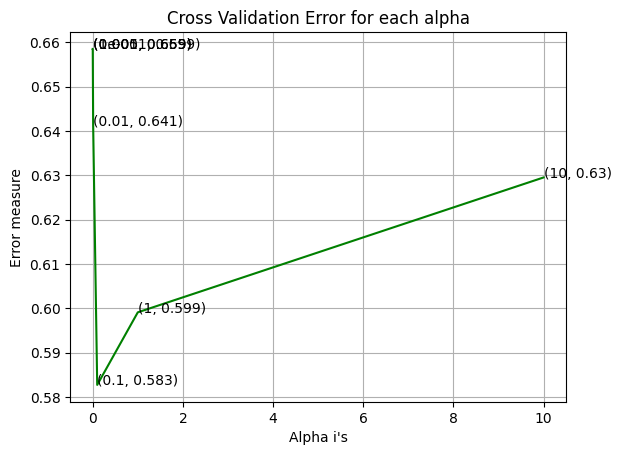

CalibratedClassifierCV(estimator=SGDClassifier(alpha=0.1, loss='log',
                                               random_state=42))

In [118]:
alpha_values = [10 ** x for x in range(-5, 2)]

log_error_values=[]
for i in alpha_values:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_values.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha_values, log_error_values,c='g')
for i, txt in enumerate(np.round(log_error_values,3)):
    ax.annotate((alpha_values[i],np.round(txt,3)), (alpha_values[i],log_error_values[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_values)
clf = SGDClassifier(alpha=alpha_values[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

In [119]:
print("Best value of alpha - ", alpha_values[best_alpha])
predict_y = sig_clf.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)

Best value of alpha -  0.1
The train log loss is: 0.5837994604444074
The test log loss is: 0.5827239969320069


In [120]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print("Accuracy Score - ", accuracy_score(y_test, predicted_y))

Accuracy Score -  0.6776942293897944


In [121]:
print("Classification Report")
print(classification_report(y_test, predicted_y))

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.87      0.77     51005
           1       0.61      0.34      0.44     29853

    accuracy                           0.68     80858
   macro avg       0.65      0.61      0.61     80858
weighted avg       0.66      0.68      0.65     80858



In [122]:
def confusion_matrix_plot(test_values, prediction_values):
    cf_matrix = confusion_matrix(test_values, prediction_values)

    precision_details =(((cf_matrix.T)/(cf_matrix.sum(axis=1))).T)

    recall_details = (cf_matrix/cf_matrix.sum(axis=0))
    plt.figure(figsize=(20,4))

    labels = [1,2]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(cf_matrix, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Value')
    plt.ylabel('Original Value')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(recall_details, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Value')
    plt.ylabel('Original Value')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    sns.heatmap(precision_details, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Value')
    plt.ylabel('Original Value')
    plt.title("Recall matrix")

    plt.show()

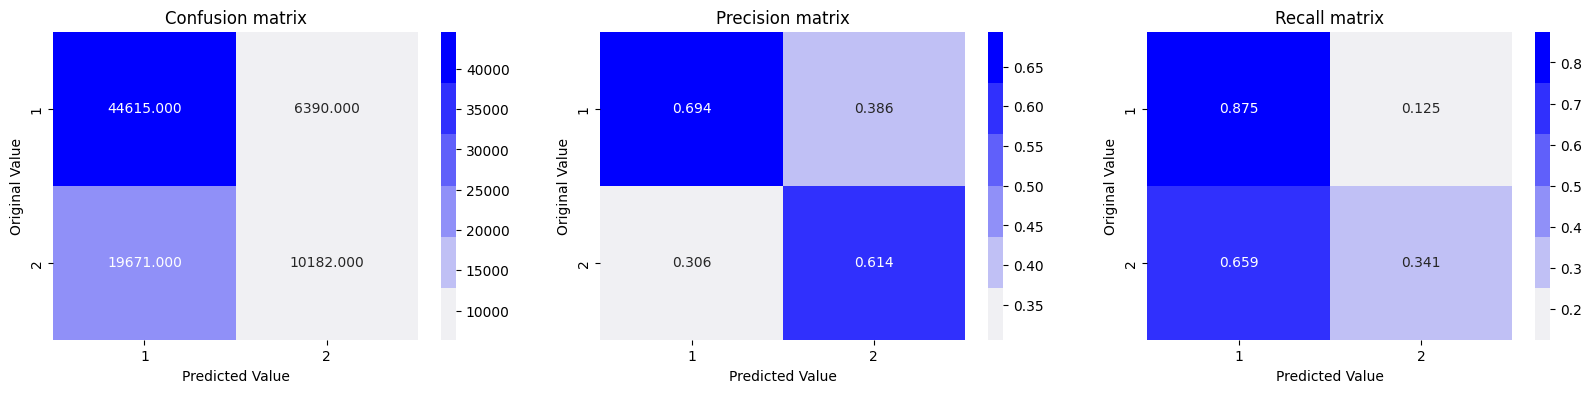

In [123]:
confusion_matrix_plot(y_test, predicted_y)